## 1. First get all boroughs and neighborhoods onto a map of Toronto, Ontario  and find their popular venues. 

## 1.1 Import modules and neighbourhoods' latitude and longitude data

In [1]:
# import all needed utilities and modules
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

In [2]:
# load neighborhoods and boroughs data in from webscraping url page with BeautifulSoup
import lxml.html as lh
from bs4 import BeautifulSoup

website_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
res = requests.get(website_url)
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 

# Fetch table content into a dataframe:
df = pd.read_html(str(table))[0]

# Format the dataframe with the required column headings and reindex the rows:
df.columns = df.iloc[0]
df = df.reindex(df.index.drop(0)).reset_index(drop=True)
df.columns.name = None

# Remove rows with 'Not assigned' Borough:
df = df[df.Borough != 'Not assigned']
# Replace 'Not assigned' Neighbourhood to 'Borough name'
df.loc[df['Neighbourhood'] =='Not assigned', 'Neighbourhood'] = df['Borough']
df.reset_index( drop=True, inplace=True)

df.head()


,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [3]:
# import the csv file with the latitude and longitude coordinates corresponding to postal code as dataframe df2
url = 'https://cocl.us/Geospatial_data'
df2 = pd.read_csv(url)
df2.columns = ['Postcode', 'Latitude','Longitude']
df2.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [4]:
# merge df and df2 on PostalCode
df_merge = pd.merge(df, df2, on='Postcode')
df_merge.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [5]:
df_merge.shape

(211, 5)

## 1.2 Create map of Toronto with the neighbourhoods marked in.

In [6]:
# Get geographical coordinates of Ontario
from geopy.geocoders import Nominatim 
address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent = 'ont_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print ('The geographical coordinates of Toronto are {},{}.'.format(latitude,longitude))

The geographical coordinates of Toronto are 43.653963,-79.387207.


In [7]:
# Create map of Toronto
!pip install folium
import folium
map_toronto = folium.Map( location=[latitude,longitude], zoom_start =11)
map_toronto

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.


In [8]:
for lat, lng, label in zip(df_merge['Latitude'], df_merge['Longitude'],df_merge['Neighbourhood']):
    label= folium.Popup(label, parse_html = True)
    folium.CircleMarker([lat,lng],
                       radius =5,
                       popup = label,
                       color='blue',
                       fill =True,
                       fill_color = '#3186cc',
                       fill_opacity = 0.7,
                       parse_html = False).add_to(map_toronto)
map_toronto

In [9]:
# Count the number of boroughs and neighborhoods
number_borough = df_merge['Borough'].nunique()
number_neighborhood = len(df_merge['Neighbourhood'])
print('There are {} boroughs and {} Neighborhoods in Toronto area.'. format((number_borough),number_neighborhood))

There are 11 boroughs and 211 Neighborhoods in Toronto area.


## 1.3 Use Foursquare API to explore the neighbourhoods

In [10]:
# @hidden_cell
CLIENT_ID ='U5BMNK0AWH3GX3HECO5FWTKV4RYYOKPYWMILJNL3LYGMCX2V'
CLIENT_SECRET = '40SPFPTH2VO0XS40IDJ4LJPEBZJ4I31CZGADB2GNV4OK0A00'
VERSION ='20180605'

print('Your Credentials: ')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Your Credentials: 
CLIENT_ID: U5BMNK0AWH3GX3HECO5FWTKV4RYYOKPYWMILJNL3LYGMCX2V
CLIENT_SECRET: 40SPFPTH2VO0XS40IDJ4LJPEBZJ4I31CZGADB2GNV4OK0A00


## 1.3.1 Generate functions to explore all neighbourhoods in Toronto.

In [11]:
#create function that extracts category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list)==0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
#Define function to get top 100 Nearby Venues (within 500 metres radius) for all neighborhoods in Toronto
LIMIT = 100
radius = 500
def getNearbyVenues( names, latitudes, longitudes, radius=500 ):
    
    venues_list = []
    
    for name, lat, lng in zip(names,latitudes, longitudes):
        print(name)
   
    #create the API request URL:
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(   
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
    # make the get requests
        results = requests.get(url).json()["response"]['groups'][0]['items']
    # return only relevant information for each nearby venue
        venues_list.append([(
                        name,
                        lat,
                        lng,
                        v['venue']['name'],
                        v['venue']['location']['lat'],
                        v['venue']['location']['lng'],
                        v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                             'Neighbourhood Latitude',
                             'Neighbourhood Longitude',
                             'Venue',
                             'venue Latitude',
                             'Venue Longitude',
                             'Venue Category']
    return(nearby_venues)          

In [13]:
# create a new dataframe by running function above for each neighborhood and called it toronto_venues
toronto_venues = getNearbyVenues( names = df_merge['Neighbourhood'],latitudes = df_merge['Latitude'],longitudes = df_merge['Longitude'])

Parkwoods
Victoria Village
Harbourfront
Regent Park
Lawrence Heights
Lawrence Manor
Queen's Park
Islington Avenue
Rouge
Malvern
Don Mills North
Woodbine Gardens
Parkview Hill
Ryerson
Garden District
Glencairn
Cloverdale
Islington
Martin Grove
Princess Gardens
West Deane Park
Highland Creek
Rouge Hill
Port Union
Flemingdon Park
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens
Eringate
Markland Wood
Old Burnhamthorpe
Guildwood
Morningside
West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Downsview North
Wilson Heights
Thorncliffe Park
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Scarborough Village
Fairview
Henry Farm
Oriole
Northwood Park
York University
East Toronto
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
East Birchmount Park
Ionview
Kennedy Park
Bayview Village
CFB Toronto
Downsview East
The Danforth West
Riverdale
Design E

In [14]:
print(toronto_venues.shape)
toronto_venues.head()

(4441, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [15]:
# check how many venues were returned for each neighborhood
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Adelaide,100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
Agincourt North,2,2,2,2,2,2
Albion Gardens,10,10,10,10,10,10
Alderwood,10,10,10,10,10,10
Bathurst Manor,18,18,18,18,18,18
Bathurst Quay,15,15,15,15,15,15
Bayview Village,4,4,4,4,4,4
Beaumond Heights,10,10,10,10,10,10


In [16]:
# find how many unique categories are there returned from all the venues
print('There are {} unique categories found.'.format(len(toronto_venues['Venue Category'].unique())))

There are 278 unique categories found.


## 1.4 Analyze each neighbourhood.

In [17]:
# use one hot encoding to apply venue category as a feature for each venue
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix ="", prefix_sep = "")
# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[ : -1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# find out size of toronto_onehot dataframe
toronto_onehot.shape

(4441, 279)

In [19]:
# group rows by neighborhood and take mean frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Adelaide,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.010000,0.000000,0.000000,0.000000,0.0000,0.010000,0.000000,0.000000,0.000000
1,Agincourt,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
2,Agincourt North,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
3,Albion Gardens,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.100000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
4,Alderwood,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
5,Bathurst Manor,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.055556,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
6,Bathurst Quay,0.0,0.000000,0.000000,0.066667,0.066667,0.066667,0.133333,0.2,0.133333,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
7,Bayview Village,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
8,Beaumond Heights,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.100000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
9,Bedford Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000


In [20]:
# check the size of toronto_grouped
toronto_grouped.shape

(203, 279)

In [21]:
# print out each neighborhood and its top 5 most common venues
num_top_venues = 5
for hood in toronto_grouped['Neighbourhood']:
    print("---" + hood + "---")
    temp = toronto_grouped[toronto_grouped['Neighbourhood']==hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq':2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---Adelaide---
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2                  Bar  0.04
3  American Restaurant  0.04
4      Thai Restaurant  0.04


---Agincourt---
            venue  freq
0    Skating Rink  0.25
1  Clothing Store  0.25
2  Breakfast Spot  0.25
3          Lounge  0.25
4           Motel  0.00


---Agincourt North---
                       venue  freq
0                 Playground   0.5
1                       Park   0.5
2          Accessories Store   0.0
3  Middle Eastern Restaurant   0.0
4                      Motel   0.0


---Albion Gardens---
                 venue  freq
0        Grocery Store   0.2
1          Pizza Place   0.1
2  Fried Chicken Joint   0.1
3       Sandwich Place   0.1
4             Pharmacy   0.1


---Alderwood---
                venue  freq
0         Pizza Place   0.2
1            Pharmacy   0.1
2                 Gym   0.1
3      Sandwich Place   0.1
4  Athletics & Sports   0.1


---Bathurst Manor---
         

## 1.5 Cast this to a DataFrame.

In [22]:
# create function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
#create dataframe and display the top ten venues for each neighborhood

num_top_venues = 10
indicators = ['st','nd','rd']
# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
#create new DataFrame
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Steakhouse,Bar,Thai Restaurant,American Restaurant,Bakery,Cosmetics Shop,Burger Joint,Hotel
1,Agincourt,Lounge,Breakfast Spot,Skating Rink,Clothing Store,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,Agincourt North,Playground,Park,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
3,Albion Gardens,Grocery Store,Pharmacy,Video Store,Sandwich Place,Coffee Shop,Beer Store,Fried Chicken Joint,Pizza Place,Fast Food Restaurant,Empanada Restaurant
4,Alderwood,Pizza Place,Gym,Skating Rink,Pharmacy,Coffee Shop,Athletics & Sports,Sandwich Place,Pool,Pub,Yoga Studio


## 1.6 Cluster neighbourhoods.


In [24]:
# Apply KMeans Clustering algorithm to cluster neighborhoods
# in view of sample size, try three clusters

from sklearn.cluster import KMeans

kclusters = 3
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(toronto_grouped_clustering)
#check cluster labels
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [25]:
# create a new Dataframe to include the cluster as well as the top ten venues for each neighborhood
# add clustering labels
neighbourhoods_venues_sorted.insert(loc = 0, column = 'Cluster Labels', value = kmeans.labels_ , allow_duplicates = False)
toronto_merged = df_merge
# merge dfs to add lat and long data
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood', how ='right')
toronto_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1,Fast Food Restaurant,Park,Food & Drink Shop,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,Intersection,Hockey Arena,Coffee Shop,Portuguese Restaurant,Pizza Place,Event Space,Ethiopian Restaurant,Empanada Restaurant,Falafel Restaurant,Electronics Store
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,1,Coffee Shop,Pub,Bakery,Park,Mexican Restaurant,Theater,Breakfast Spot,Café,Gym / Fitness Center,Health Food Store
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636,1,Coffee Shop,Pub,Bakery,Park,Mexican Restaurant,Theater,Breakfast Spot,Café,Gym / Fitness Center,Health Food Store
4,M6A,North York,Lawrence Heights,43.718518,-79.464763,1,Clothing Store,Furniture / Home Store,Women's Store,Boutique,Gift Shop,Event Space,Miscellaneous Shop,Coffee Shop,Accessories Store,Vietnamese Restaurant


In [26]:
print(kmeans.labels_)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 0 1 1 1 1 2 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## 1.7 Create map to show clusters.

In [27]:
#create map
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import rgb2hex
import matplotlib.cm as cm
map_clusters = folium.Map(location=[latitude,longitude], zoom_start =11)

# set color scheme for clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#add markers to map
markers_color = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + 'Cluster'+ str(cluster), parse_html = True)
    folium.CircleMarker(
            [lat,lon],
            radius = 5,
            popup = label,
            color = rainbow [cluster -1],
            fill = True,
            fill_color = rainbow [cluster -1],
            fill_opacity = 0.7). add_to (map_clusters)
            
map_clusters

## 1.8 Examine each of the three clusters

In [28]:
# look at cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels']==0,toronto_merged.columns[[1]+ list(range(5,toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
106,North York,0,Baseball Field,Construction & Landscaping,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
107,North York,0,Baseball Field,Construction & Landscaping,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
198,Etobicoke,0,Baseball Field,Locksmith,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
199,Etobicoke,0,Baseball Field,Locksmith,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
200,Etobicoke,0,Baseball Field,Locksmith,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
201,Etobicoke,0,Baseball Field,Locksmith,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
202,Etobicoke,0,Baseball Field,Locksmith,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
203,Etobicoke,0,Baseball Field,Locksmith,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
204,Etobicoke,0,Baseball Field,Locksmith,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
205,Etobicoke,0,Baseball Field,Locksmith,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store


In [29]:
# look at cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels']==1, toronto_merged.columns[[1] + list(range(5,toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,1,Fast Food Restaurant,Park,Food & Drink Shop,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
1,North York,1,Intersection,Hockey Arena,Coffee Shop,Portuguese Restaurant,Pizza Place,Event Space,Ethiopian Restaurant,Empanada Restaurant,Falafel Restaurant,Electronics Store
2,Downtown Toronto,1,Coffee Shop,Pub,Bakery,Park,Mexican Restaurant,Theater,Breakfast Spot,Café,Gym / Fitness Center,Health Food Store
3,Downtown Toronto,1,Coffee Shop,Pub,Bakery,Park,Mexican Restaurant,Theater,Breakfast Spot,Café,Gym / Fitness Center,Health Food Store
4,North York,1,Clothing Store,Furniture / Home Store,Women's Store,Boutique,Gift Shop,Event Space,Miscellaneous Shop,Coffee Shop,Accessories Store,Vietnamese Restaurant
5,North York,1,Clothing Store,Furniture / Home Store,Women's Store,Boutique,Gift Shop,Event Space,Miscellaneous Shop,Coffee Shop,Accessories Store,Vietnamese Restaurant
6,Queen's Park,1,Coffee Shop,Gym,Japanese Restaurant,Sushi Restaurant,Park,Persian Restaurant,Smoothie Shop,Seafood Restaurant,Sandwich Place,Burger Joint
8,Scarborough,1,Fast Food Restaurant,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
9,Scarborough,1,Fast Food Restaurant,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
10,North York,1,Basketball Court,Baseball Field,Caribbean Restaurant,Café,Japanese Restaurant,Gym / Fitness Center,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store


In [30]:
# look at cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels']==2, toronto_merged.columns[[1] + list(range(5,toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Etobicoke,2,Bank,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Diner
17,Etobicoke,2,Bank,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Diner
18,Etobicoke,2,Bank,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Diner
19,Etobicoke,2,Bank,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Diner
20,Etobicoke,2,Bank,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Diner


## 2. Get demographic, crime and economy type data about neighbourhoods from Wellbeing Toronto Web Mapping App (www.map.toronto.ca/wellbeing/....)

In [31]:
import pandas as pd
#import neighbourhoods' demographic, crime and economy data extracted from wellbeing_toronto 2014 portal(www.map.toronto.ca/wellbeing/....) datasets
url ='https://raw.githubusercontent.com/kunyew/Notebook-for-Capstone-Project/master/wellbeing_toronto.csv'
data = pd.read_csv(url, header ='infer')
data.head()

,Neighbourhood,Neighbourhood Id,Combined Indicators,Visible Minority Category,Total Population,Average Family Income,Unemployed,Break & Enters,Robberies,Chinese,Korean,Japanese
0,West Humber-Clairville,1.0,NaN,32890.0,33312.0,72820.0,1705.0,131.0,82.0,470.0,60.0,60.0
1,Mount Olive-Silverstone-Jamestown,2.0,NaN,32830.0,32954.0,57411.0,1785.0,34.0,81.0,285.0,70.0,10.0
2,Thistletown-Beaumond Heights,3.0,NaN,10125.0,10360.0,70838.0,525.0,23.0,12.0,110.0,40.0,15.0
3,Rexdale-Kipling,4.0,NaN,10360.0,10529.0,69367.0,600.0,16.0,15.0,165.0,10.0,35.0
4,Elms-Old Rexdale,5.0,NaN,9445.0,9456.0,61196.0,465.0,9.0,14.0,105.0,105.0,15.0


In [32]:
data.shape

(140, 12)

## N.B. The number of neighbourhoods in 2014 census data was 140 compared with 211 in 2019. So some  neighbourhoods will not be analyzed in the sections to follow, as they are not in the 'wellbeing Toronto' App. 

## 3. Clean Data.

In [33]:
# drop "neighbourhood Id" & "Combined indicators" columns and clean remaining data column names of white spaces
list = ['Neighbourhood Id','Combined Indicators']
data = data.drop(columns=list, axis=1)
data.columns=data.columns.str.strip() #remove white spaces in column names
data.head()

,Neighbourhood,Visible Minority Category,Total Population,Average Family Income,Unemployed,Break & Enters,Robberies,Chinese,Korean,Japanese
0,West Humber-Clairville,32890.0,33312.0,72820.0,1705.0,131.0,82.0,470.0,60.0,60.0
1,Mount Olive-Silverstone-Jamestown,32830.0,32954.0,57411.0,1785.0,34.0,81.0,285.0,70.0,10.0
2,Thistletown-Beaumond Heights,10125.0,10360.0,70838.0,525.0,23.0,12.0,110.0,40.0,15.0
3,Rexdale-Kipling,10360.0,10529.0,69367.0,600.0,16.0,15.0,165.0,10.0,35.0
4,Elms-Old Rexdale,9445.0,9456.0,61196.0,465.0,9.0,14.0,105.0,105.0,15.0


## 4. Extract  ethnic groups (Chinese, Korean and Japanese) data sub-set 

In [34]:
df_ethnic_group = data[['Neighbourhood', 'Total Population','Visible Minority Category', 'Chinese','Korean', 'Japanese']]
df_ethnic_group.head()

,Neighbourhood,Total Population,Visible Minority Category,Chinese,Korean,Japanese
0,West Humber-Clairville,33312.0,32890.0,470.0,60.0,60.0
1,Mount Olive-Silverstone-Jamestown,32954.0,32830.0,285.0,70.0,10.0
2,Thistletown-Beaumond Heights,10360.0,10125.0,110.0,40.0,15.0
3,Rexdale-Kipling,10529.0,10360.0,165.0,10.0,35.0
4,Elms-Old Rexdale,9456.0,9445.0,105.0,105.0,15.0


## 5. Extract crime, unemployed and average family income data subset.

In [35]:
df_income = data[['Neighbourhood','Total Population','Average Family Income','Unemployed','Break & Enters','Robberies']]
df_income.head()

,Neighbourhood,Total Population,Average Family Income,Unemployed,Break & Enters,Robberies
0,West Humber-Clairville,33312.0,72820.0,1705.0,131.0,82.0
1,Mount Olive-Silverstone-Jamestown,32954.0,57411.0,1785.0,34.0,81.0
2,Thistletown-Beaumond Heights,10360.0,70838.0,525.0,23.0,12.0
3,Rexdale-Kipling,10529.0,69367.0,600.0,16.0,15.0
4,Elms-Old Rexdale,9456.0,61196.0,465.0,9.0,14.0


## 6. Get supplementary economic data from www.opendata.ca/social.development/wellbeing/WB-Economics.xlsx (2011 dataset)

In [36]:

xlsx = pd.ExcelFile('http://opendata.toronto.ca/social.development/wellbeing/WB-Economics.xlsx')
e_data = pd.read_excel(xlsx, r'RawData-Ref Period 2011', skiprows =[0], index_col = None)

#Clean data
new_header = e_data.iloc[0] # grab first row as header
e_data = e_data[ : ].reset_index(drop=True) # take data less header row

#e_data.columns = new_header
e_data.head()

,Neighbourhood,Neighbourhood Id,Businesses,Child Care Spaces,Debt Risk Score,Home Prices,Local Employment,Social Assistance Recipients
0,West Humber-Clairville,1,2463,195,719,317508,58271,2912
1,Mount Olive-Silverstone-Jamestown,2,271,60,687,251119,3244,6561
2,Thistletown-Beaumond Heights,3,217,25,718,414216,1311,1276
3,Rexdale-Kipling,4,144,75,721,392271,1178,1323
4,Elms-Old Rexdale,5,67,60,692,233832,903,1683


In [37]:
df_employment = e_data[['Neighbourhood','Businesses','Home Prices','Local Employment','Social Assistance Recipients']]
df_employment.head()

,Neighbourhood,Businesses,Home Prices,Local Employment,Social Assistance Recipients
0,West Humber-Clairville,2463,317508,58271,2912
1,Mount Olive-Silverstone-Jamestown,271,251119,3244,6561
2,Thistletown-Beaumond Heights,217,414216,1311,1276
3,Rexdale-Kipling,144,392271,1178,1323
4,Elms-Old Rexdale,67,233832,903,1683


In [38]:
df_employment.shape #check sub dataset has similar number of rows as 'data' subset above.

(140, 5)

In [39]:
# get economic data ('average family income' and 'home prices' from two dataframes together in one for 'wealth' attribute.)
df_inc_emp = pd.merge(df_income, df_employment, on ='Neighbourhood')
df_inc_emp.head()

,Neighbourhood,Total Population,Average Family Income,Unemployed,Break & Enters,Robberies,Businesses,Home Prices,Local Employment,Social Assistance Recipients
0,West Humber-Clairville,33312.0,72820.0,1705.0,131.0,82.0,2463,317508,58271,2912
1,Mount Olive-Silverstone-Jamestown,32954.0,57411.0,1785.0,34.0,81.0,271,251119,3244,6561
2,Thistletown-Beaumond Heights,10360.0,70838.0,525.0,23.0,12.0,217,414216,1311,1276
3,Rexdale-Kipling,10529.0,69367.0,600.0,16.0,15.0,144,392271,1178,1323
4,Elms-Old Rexdale,9456.0,61196.0,465.0,9.0,14.0,67,233832,903,1683


## 7. Visualize 'Wealth' Data, Crime Data, Ethnic distribution by neighbourhoods 

### 7.1 Compare unemployed, crimes rates, average family income, house prices by neighourhoods.

In [40]:
# Get some statistics and quartile distribution thresholds for the numeric attributes 
df_inc_emp.describe()

,Total Population,Average Family Income,Unemployed,Break & Enters,Robberies,Businesses,Home Prices,Local Employment,Social Assistance Recipients
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,1.400000e+02,140.0000,140.000000
mean,19511.221429,89583.792857,873.892857,45.221429,20.935714,536.321429,5.481934e+05,9409.3500,1864.700000
std,10033.589222,43030.520280,493.842687,31.438891,20.128083,637.210719,2.676674e+05,19125.3383,1504.562647
min,6577.000000,49005.000000,255.000000,8.000000,0.000000,47.000000,2.041040e+05,438.0000,37.000000
25%,12019.500000,65842.500000,521.250000,24.000000,8.000000,169.750000,3.749645e+05,2069.5000,697.000000
50%,16749.500000,76857.000000,747.500000,37.500000,15.000000,345.500000,4.912100e+05,4052.5000,1455.000000
75%,23854.500000,92803.750000,1080.000000,57.000000,25.000000,591.000000,5.902160e+05,10127.0000,2682.750000
max,65913.000000,356777.000000,2665.000000,213.000000,112.000000,4324.000000,1.849084e+06,185891.0000,7263.000000


In [41]:
# crime rate percent is computed as sum of 'Break & Enters' and 'Robberies' divided by 'Total Population'
df_inc_emp['Crime Rate Percent'] = 100*(df_inc_emp['Break & Enters']+ df_inc_emp['Robberies'])/(df_inc_emp['Total Population'])
df_inc_emp.drop(columns=['Break & Enters', 'Robberies'], axis=1, inplace=True)
df_inc_emp.head()

,Neighbourhood,Total Population,Average Family Income,Unemployed,Businesses,Home Prices,Local Employment,Social Assistance Recipients,Crime Rate Percent
0,West Humber-Clairville,33312.0,72820.0,1705.0,2463,317508,58271,2912,0.639409
1,Mount Olive-Silverstone-Jamestown,32954.0,57411.0,1785.0,271,251119,3244,6561,0.348971
2,Thistletown-Beaumond Heights,10360.0,70838.0,525.0,217,414216,1311,1276,0.337838
3,Rexdale-Kipling,10529.0,69367.0,600.0,144,392271,1178,1323,0.294425
4,Elms-Old Rexdale,9456.0,61196.0,465.0,67,233832,903,1683,0.243232


In [42]:
# Unemployed rate as percent of population
df_inc_emp['Unemployed Rate']= 100*(df_inc_emp['Unemployed'])/df_inc_emp['Total Population']
df_inc_emp.drop('Unemployed', axis=1, inplace=True)
df_inc_emp.head()

,Neighbourhood,Total Population,Average Family Income,Businesses,Home Prices,Local Employment,Social Assistance Recipients,Crime Rate Percent,Unemployed Rate
0,West Humber-Clairville,33312.0,72820.0,2463,317508,58271,2912,0.639409,5.118276
1,Mount Olive-Silverstone-Jamestown,32954.0,57411.0,271,251119,3244,6561,0.348971,5.416641
2,Thistletown-Beaumond Heights,10360.0,70838.0,217,414216,1311,1276,0.337838,5.067568
3,Rexdale-Kipling,10529.0,69367.0,144,392271,1178,1323,0.294425,5.698547
4,Elms-Old Rexdale,9456.0,61196.0,67,233832,903,1683,0.243232,4.917513


In [43]:
# Set up dataframe for 'wealth', 'crime rate' and 'unemployed rate' to filter neighbourhoods
df_inc_emp2 = df_inc_emp[['Neighbourhood','Total Population','Average Family Income', 'Home Prices', 'Crime Rate Percent','Unemployed Rate']]
df_inc_emp2.head()

,Neighbourhood,Total Population,Average Family Income,Home Prices,Crime Rate Percent,Unemployed Rate
0,West Humber-Clairville,33312.0,72820.0,317508,0.639409,5.118276
1,Mount Olive-Silverstone-Jamestown,32954.0,57411.0,251119,0.348971,5.416641
2,Thistletown-Beaumond Heights,10360.0,70838.0,414216,0.337838,5.067568
3,Rexdale-Kipling,10529.0,69367.0,392271,0.294425,5.698547
4,Elms-Old Rexdale,9456.0,61196.0,233832,0.243232,4.917513


In [44]:
# Detect any nan in df_inc_emp2
df_inc_emp2.isnull().values.any()

False

In [45]:
# Set up data for boxploting the wealth, crime rate and unemployed rate
df_box = df_inc_emp2[['Average Family Income', 'Home Prices','Crime Rate Percent','Unemployed Rate']]
df_box.head()

,Average Family Income,Home Prices,Crime Rate Percent,Unemployed Rate
0,72820.0,317508,0.639409,5.118276
1,57411.0,251119,0.348971,5.416641
2,70838.0,414216,0.337838,5.067568
3,69367.0,392271,0.294425,5.698547
4,61196.0,233832,0.243232,4.917513


In [46]:
# Get some statistics and quartile distribution for boxplotting
df_inc_emp2.describe()

,Total Population,Average Family Income,Home Prices,Crime Rate Percent,Unemployed Rate
count,140.000000,140.000000,1.400000e+02,140.000000,140.000000
mean,19511.221429,89583.792857,5.481934e+05,0.341266,4.409977
std,10033.589222,43030.520280,2.676674e+05,0.160173,0.745232
min,6577.000000,49005.000000,2.041040e+05,0.106569,2.761833
25%,12019.500000,65842.500000,3.749645e+05,0.242904,3.894406
50%,16749.500000,76857.000000,4.912100e+05,0.308931,4.381260
75%,23854.500000,92803.750000,5.902160e+05,0.419172,4.972118
max,65913.000000,356777.000000,1.849084e+06,1.175266,6.500542


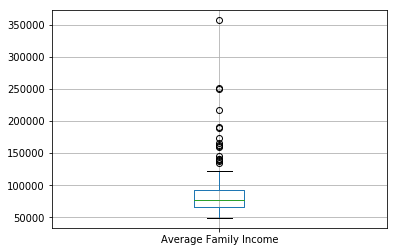

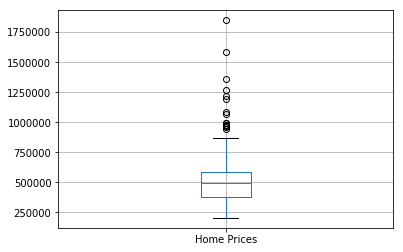

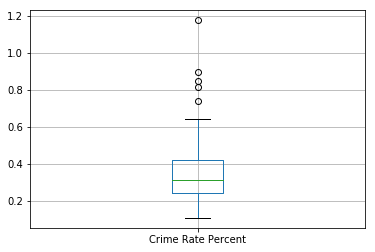

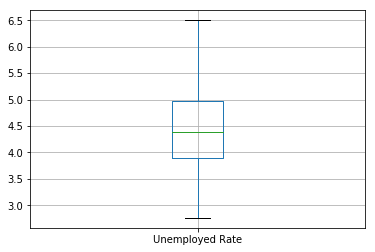

In [47]:
# Box Plot to visualize wealth, crime rate and unemployed rate in the neighbourhoods
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 24))
for column in df_box:
    plt.figure()
    df_box.boxplot([column])
    plt.show()

* **We classify 'Affluent' neighbourhoods as those in the 4th or top quartile measures of 'Average Family Income' and 'Home Prices'.**    
* **We classify 'Super Affluent' neighbourhoods as those in the outliers in the measures of 'Average family income' and 'Home Prices'.**    
* **We classify 'Safe' neighbourhoods as those in the first quartile of bottom quartile measured by 'Crime Rate' and 'Unemployed Rate'.**  

### 7.2 Next we find these 'Affluent' and 'Safe' neighbourhoods categories.

In [48]:
df_ethnic_group.head()

,Neighbourhood,Total Population,Visible Minority Category,Chinese,Korean,Japanese
0,West Humber-Clairville,33312.0,32890.0,470.0,60.0,60.0
1,Mount Olive-Silverstone-Jamestown,32954.0,32830.0,285.0,70.0,10.0
2,Thistletown-Beaumond Heights,10360.0,10125.0,110.0,40.0,15.0
3,Rexdale-Kipling,10529.0,10360.0,165.0,10.0,35.0
4,Elms-Old Rexdale,9456.0,9445.0,105.0,105.0,15.0


In [49]:
# set up data for statistics and boxplotting
df_ethnic_group.describe()

,Total Population,Visible Minority Category,Chinese,Korean,Japanese
count,140.000000,140.000000,140.000000,140.000000,140.00000
mean,19511.221429,19226.571429,2139.178571,297.500000,96.00000
std,10033.589222,9942.217973,3526.503282,572.521402,89.73422
min,6577.000000,6370.000000,100.000000,0.000000,0.00000
25%,12019.500000,11970.000000,448.750000,58.750000,38.75000
50%,16749.500000,16532.500000,840.000000,130.000000,70.00000
75%,23854.500000,23507.500000,1955.000000,258.750000,126.25000
max,65913.000000,65620.000000,18715.000000,5255.000000,665.00000


In [50]:
# Combine 'Chinese','Korean' and 'Japanese' into a new group 'e_asians'
df_ethnic_group['e_asians'] = df_ethnic_group['Chinese'] + df_ethnic_group['Korean'] + df_ethnic_group['Japanese']
df_ethnic_group.head()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Neighbourhood,Total Population,Visible Minority Category,Chinese,Korean,Japanese,e_asians
0,West Humber-Clairville,33312.0,32890.0,470.0,60.0,60.0,590.0
1,Mount Olive-Silverstone-Jamestown,32954.0,32830.0,285.0,70.0,10.0,365.0
2,Thistletown-Beaumond Heights,10360.0,10125.0,110.0,40.0,15.0,165.0
3,Rexdale-Kipling,10529.0,10360.0,165.0,10.0,35.0,210.0
4,Elms-Old Rexdale,9456.0,9445.0,105.0,105.0,15.0,225.0


In [51]:
# Compute 'e_asians' as percent of 'visible minority category'
df_ethnic_group['e_asian_percent'] = 100*(df_ethnic_group['e_asians'])/(df_ethnic_group['Visible Minority Category'])
df_ethnic_group.head()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Neighbourhood,Total Population,Visible Minority Category,Chinese,Korean,Japanese,e_asians,e_asian_percent
0,West Humber-Clairville,33312.0,32890.0,470.0,60.0,60.0,590.0,1.793858
1,Mount Olive-Silverstone-Jamestown,32954.0,32830.0,285.0,70.0,10.0,365.0,1.111788
2,Thistletown-Beaumond Heights,10360.0,10125.0,110.0,40.0,15.0,165.0,1.629630
3,Rexdale-Kipling,10529.0,10360.0,165.0,10.0,35.0,210.0,2.027027
4,Elms-Old Rexdale,9456.0,9445.0,105.0,105.0,15.0,225.0,2.382213


In [52]:
# get statistics and quartile distribution for numeric data columns in dataframe.
df_ethnic_group.describe()

,Total Population,Visible Minority Category,Chinese,Korean,Japanese,e_asians,e_asian_percent
count,140.000000,140.000000,140.000000,140.000000,140.00000,140.000000,140.000000
mean,19511.221429,19226.571429,2139.178571,297.500000,96.00000,2532.678571,11.621524
std,10033.589222,9942.217973,3526.503282,572.521402,89.73422,3840.514448,13.607949
min,6577.000000,6370.000000,100.000000,0.000000,0.00000,125.000000,1.111788
25%,12019.500000,11970.000000,448.750000,58.750000,38.75000,610.000000,4.015556
50%,16749.500000,16532.500000,840.000000,130.000000,70.00000,1037.500000,6.846604
75%,23854.500000,23507.500000,1955.000000,258.750000,126.25000,2432.500000,11.323194
max,65913.000000,65620.000000,18715.000000,5255.000000,665.00000,22900.000000,73.913043


In [53]:
# Set up data to visualize the distribution of 'Chinese', 'Korean' and 'Japanese' ethnic groups distribution in the neighbourhoods
df_box_ethnic = df_ethnic_group[['Chinese','Korean','Japanese']]
df_box_ethnic.head()

,Chinese,Korean,Japanese
0,470.0,60.0,60.0
1,285.0,70.0,10.0
2,110.0,40.0,15.0
3,165.0,10.0,35.0
4,105.0,105.0,15.0


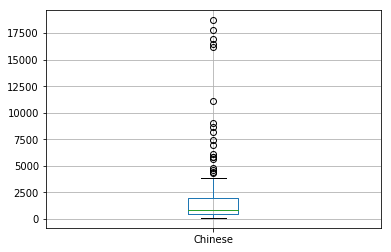

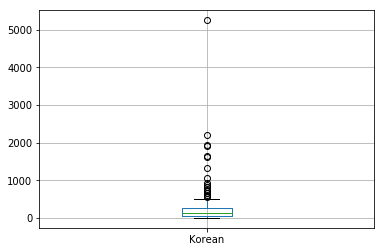

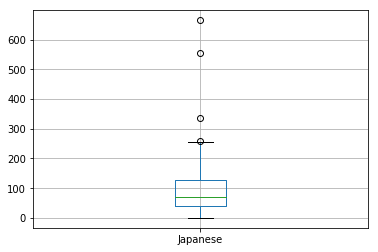

In [54]:
# Box plot the distributions
fig = plt.figure(figsize=(16,24))
for column in df_box_ethnic:
    plt.figure()
    df_box_ethnic.boxplot([column])
    plt.show()


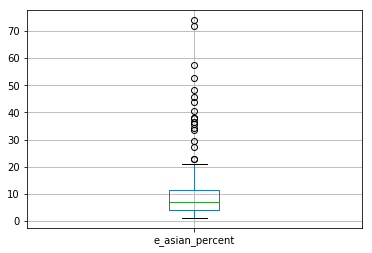

In [55]:
# Distribution of e_asians as a group in neighbourhoods
df_ethnic_group.boxplot(column=['e_asian_percent'])

* *Indentifiable high number of 'pockets' of neighbourhoods (outliers) has high presence of e_asians as visible minority category.* 

### We target to locate in neighbourhoods where east asians are in top quartile of "east_asians as percent of visible minority category"



### 7.3 Find the neighbourhoods by 'Affluent', 'Safe' and ' e_asians' (concentration) categories using filter criteria


In [56]:
# Filter for 'Affluent' neighbourhoods
condition_1 = df_inc_emp2['Average Family Income'] >= 92803.75
condition_2 = df_inc_emp2['Home Prices'] >= 590216.00
df_affluent = df_inc_emp2.loc[condition_1 & condition_2]
df_affluent.head()

,Neighbourhood,Total Population,Average Family Income,Home Prices,Crime Rate Percent,Unemployed Rate
8,Edenbridge-Humber Valley,15535.0,119581.0,873268,0.315417,3.282910
9,Princess-Rosethorn,11051.0,144943.0,971668,0.479595,3.212379
14,Kingsway South,9271.0,191204.0,941223,0.377521,3.883076
15,Stonegate-Queensway,25051.0,100867.0,690949,0.247495,3.732386
37,Lansing-Westgate,16164.0,105947.0,646460,0.309329,4.114081


In [57]:
#Filter for 'Safe' neighbourhoods
condition_3 = df_inc_emp2['Crime Rate Percent'] <= 0.242904
condition_4 = df_inc_emp2['Unemployed Rate'] <= 3.894406
df_safe = df_inc_emp2.loc[condition_3 & condition_4]
df_safe.head()

,Neighbourhood,Total Population,Average Family Income,Home Prices,Crime Rate Percent,Unemployed Rate
16,Mimico,33964.0,87901.0,429941,0.161936,3.842304
27,Rustic,9941.0,59004.0,493442,0.211246,3.772256
41,Banbury-Don Mills,27695.0,115239.0,613647,0.241921,3.646868
55,Leaside-Bennington,16828.0,158847.0,1071823,0.237699,3.773473
86,High Park-Swansea,23925.0,116465.0,622206,0.217346,3.615465


In [58]:
# 'Target' safe and affluent neighbourhoods are at intersection of df_affluent and df_safe
df_safe_affluent = pd.merge(df_safe, df_affluent, how='inner', on=['Neighbourhood']) 
df_safe_affluent.head()

,Neighbourhood,Total Population_x,Average Family Income_x,Home Prices_x,Crime Rate Percent_x,Unemployed Rate_x,Total Population_y,Average Family Income_y,Home Prices_y,Crime Rate Percent_y,Unemployed Rate_y
0,Banbury-Don Mills,27695.0,115239.0,613647,0.241921,3.646868,27695.0,115239.0,613647,0.241921,3.646868
1,Leaside-Bennington,16828.0,158847.0,1071823,0.237699,3.773473,16828.0,158847.0,1071823,0.237699,3.773473
2,High Park-Swansea,23925.0,116465.0,622206,0.217346,3.615465,23925.0,116465.0,622206,0.217346,3.615465
3,Casa Loma,10968.0,188924.0,1083381,0.182349,3.874909,10968.0,188924.0,1083381,0.182349,3.874909
4,Yonge-St.Clair,12528.0,173751.0,995616,0.143678,3.631865,12528.0,173751.0,995616,0.143678,3.631865


In [59]:
# How many of these ?
len(df_safe_affluent)

6

In [60]:
# df with top quartile e_asians presence
df_e_asians = df_ethnic_group[df_ethnic_group['e_asian_percent']>= 11.323]
df_e_asians.head()

,Neighbourhood,Total Population,Visible Minority Category,Chinese,Korean,Japanese,e_asians,e_asian_percent
35,Newtonbrook West,23831.0,23620.0,2650.0,2210.0,100.0,4960.0,20.999153
36,Willowdale West,16936.0,16670.0,3655.0,1930.0,145.0,5730.0,34.373125
37,Lansing-Westgate,16164.0,16065.0,1740.0,875.0,70.0,2685.0,16.713352
39,St.Andrew-Windfields,17812.0,17675.0,3845.0,820.0,145.0,4810.0,27.213579
40,Bridle Path-Sunnybrook-York Mills,9266.0,9185.0,1410.0,185.0,55.0,1650.0,17.964072


In [61]:
#How many ?
len(df_e_asians)

35

In [62]:
# 'Target' neighbourhoods classified as 'Safe, Affluent and High e_asians presence
df_chosen = pd.merge(df_safe_affluent, df_e_asians, how = 'inner', on=['Neighbourhood'])
df_chosen.head()

,Neighbourhood,Total Population_x,Average Family Income_x,Home Prices_x,Crime Rate Percent_x,Unemployed Rate_x,Total Population_y,Average Family Income_y,Home Prices_y,Crime Rate Percent_y,Unemployed Rate_y,Total Population,Visible Minority Category,Chinese,Korean,Japanese,e_asians,e_asian_percent
0,Banbury-Don Mills,27695.0,115239.0,613647,0.241921,3.646868,27695.0,115239.0,613647,0.241921,3.646868,27695.0,26995.0,4630.0,560.0,210.0,5400.0,20.003704


## 8. Filters set result in one neighbourhood, as 'Safe, 'Affluent' and 'High e_asians' : Banbury-Don Mills.

## 8.1 Use Foursquare API to check the trending venues and restaurants in Branbury-Don Mills neighbourhood

In [63]:
# Get geographical coordinates of Branbury-Don Mills
from geopy.geocoders import Nominatim
address = 'Banbury-Don Mills, Toronto'
geolocator= Nominatim(user_agent = 'ont_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The Geographical coordinates of Banbury-Don Mills are {},{}.'.format (latitude,longitude))

The Geographical coordinates of Banbury-Don Mills are 43.7348039,-79.3572426.


In [64]:
# create map of neighbourhood

import folium
map_banbury_dm = folium.Map(location = [latitude, longitude], zoom_start =11)
map_banbury_dm

In [65]:
# @hidden_cell
# Get venues in neighbourhood from Foursquare API

CLIENT_ID ='U5BMNK0AWH3GX3HECO5FWTKV4RYYOKPYWMILJNL3LYGMCX2V'
CLIENT_SECRET = '40SPFPTH2VO0XS40IDJ4LJPEBZJ4I31CZGADB2GNV4OK0A00'
VERSION ='20180605'

print('Your Credentials: ')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Your Credentials: 
CLIENT_ID: U5BMNK0AWH3GX3HECO5FWTKV4RYYOKPYWMILJNL3LYGMCX2V
CLIENT_SECRET: 40SPFPTH2VO0XS40IDJ4LJPEBZJ4I31CZGADB2GNV4OK0A00


In [66]:
neighbourhood_latitude = latitude
neighbourhood_longitude = longitude

In [67]:
# create get results url
LIMIT =100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
       CLIENT_ID,
       CLIENT_SECRET,
       VERSION,
       neighbourhood_latitude,
       neighbourhood_longitude,
       radius,
       LIMIT )
url

'https://api.foursquare.com/v2/venues/explore?client_id=U5BMNK0AWH3GX3HECO5FWTKV4RYYOKPYWMILJNL3LYGMCX2V&client_secret=40SPFPTH2VO0XS40IDJ4LJPEBZJ4I31CZGADB2GNV4OK0A00&v=20180605&ll=43.7348039,-79.3572426&radius=500&limit=100'

In [68]:
import json
import requests
from pandas.io.json import json_normalize
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5cefca86dd57970e23bb113c'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4bd631a75631c9b6998fa530-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d163941735',
         'name': 'Park',
         'pluralName': 'Parks',
         'primary': True,
         'shortName': 'Park'}],
       'id': '4bd631a75631c9b6998fa530',
       'location': {'address': '755 Lawrence Ave E',
        'cc': 'CA',
        'city': 'Toronto',
        'country': 'Canada',
        'distance': 162,
        'formattedAddress': ['755 Lawrence Ave E',
         'Toronto ON M3C 1P2',
         'Canada'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.73357397323459,
    

In [69]:
#create function that extracts category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list)==0:
        return None
    else:
        return categories_list[0]['name']

In [70]:
# clean json and structure to DataFrame
from pandas.io.json import json_normalize
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
#filter columns
filtered_columns = ['venue.name', 'venue.categories','venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[ : , filtered_columns]
#filter category
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
#clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,Edwards Gardens,Park,43.733574,-79.358329
1,Toronto Botanical Garden,Park,43.734104,-79.358321
2,Tim Hortons,Coffee Shop,43.735150,-79.355647
3,Don Mills Trail North,Trail,43.734676,-79.354866
4,Lawrence Ave E & Leslie Ave,Intersection,43.734680,-79.355854


In [71]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

5 venues were returned by Foursquare.


## 8.2 No restaurants are returned as venues from this neighbourhood. Possible low trending. Site for a start up restaurant (East Asian cuisine) ? Increase radius to 1 km and check again.

In [72]:
# Investigate within 1 km radius to see if there are neighbouring restaurants further 
# create get results url
LIMIT =100
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
       CLIENT_ID,
       CLIENT_SECRET,
       VERSION,
       neighbourhood_latitude,
       neighbourhood_longitude,
       radius,
       LIMIT )
url

'https://api.foursquare.com/v2/venues/explore?client_id=U5BMNK0AWH3GX3HECO5FWTKV4RYYOKPYWMILJNL3LYGMCX2V&client_secret=40SPFPTH2VO0XS40IDJ4LJPEBZJ4I31CZGADB2GNV4OK0A00&v=20180605&ll=43.7348039,-79.3572426&radius=1000&limit=100'

In [73]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5cefcaacdb04f52f63168d94'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4bd631a75631c9b6998fa530-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d163941735',
         'name': 'Park',
         'pluralName': 'Parks',
         'primary': True,
         'shortName': 'Park'}],
       'id': '4bd631a75631c9b6998fa530',
       'location': {'address': '755 Lawrence Ave E',
        'cc': 'CA',
        'city': 'Toronto',
        'country': 'Canada',
        'distance': 162,
        'formattedAddress': ['755 Lawrence Ave E',
         'Toronto ON M3C 1P2',
         'Canada'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.73357397323459,
    

In [74]:
#create function that extracts category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list)==0:
        return None
    else:
        return categories_list[0]['name']

In [75]:
# clean json and structure to DataFrame
from pandas.io.json import json_normalize
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
#filter columns
filtered_columns = ['venue.name', 'venue.categories','venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[ : , filtered_columns]
#filter category
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
#clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues

,name,categories,lat,lng
0,Edwards Gardens,Park,43.733574,-79.358329
1,Toronto Botanical Garden,Park,43.734104,-79.358321
2,Congee Queen 皇后名粥,Cantonese Restaurant,43.735977,-79.347356
3,Cineplex VIP Cinemas Don Mills,Movie Theater,43.734279,-79.346164
4,Aroma Espresso Bar,Café,43.734400,-79.345204
5,Ice 'n Cake,Ice Cream Shop,43.734292,-79.345198
6,Anthropologie,Women's Store,43.733996,-79.345564
7,Lindt & Sprüngli,Chocolate Shop,43.734806,-79.345240
8,McEwan,Gourmet Shop,43.736256,-79.345132
9,Tim Hortons,Coffee Shop,43.735150,-79.355647


In [76]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

25 venues were returned by Foursquare.


## 8.3 Within 1 km radius there is 1 Cantonese Restaurant and 2 American restaurants. So room for another restaurant of E Asian cuisine ( Chinese, Japanese or Korean or a fusion of these.)

In [77]:
# Check the ethnic composition at this neighbourhood
df_chosen

,Neighbourhood,Total Population_x,Average Family Income_x,Home Prices_x,Crime Rate Percent_x,Unemployed Rate_x,Total Population_y,Average Family Income_y,Home Prices_y,Crime Rate Percent_y,Unemployed Rate_y,Total Population,Visible Minority Category,Chinese,Korean,Japanese,e_asians,e_asian_percent
0,Banbury-Don Mills,27695.0,115239.0,613647,0.241921,3.646868,27695.0,115239.0,613647,0.241921,3.646868,27695.0,26995.0,4630.0,560.0,210.0,5400.0,20.003704


## Recommendation is either a Korean restaurant (Hot Pot cuisine) or Japanese (Sushi, Sashimi, Teppan Yaki) as there is already presence of a reknown Chinese Restaurant. 

## 8.4 Cross-check with 1.6 analysis of clusters and popular venues for the Neighbourhood of Banbury-Don Mills (from Dataframe: neighbourhoods_venues_sorted), listed as 'Don Mills North' and 'Don Mills South'.


In [78]:
neighbourhoods_venues_sorted.index[neighbourhoods_venues_sorted['Neighbourhood'] == 'Don Mills North'].tolist()


[37]

In [79]:
neighbourhoods_venues_sorted.index[neighbourhoods_venues_sorted['Neighbourhood'] == 'Don Mills South'].tolist()

[38]

In [80]:
df_dm = neighbourhoods_venues_sorted.iloc[37:39 , : ]
df_dm

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,1,Don Mills North,Basketball Court,Baseball Field,Caribbean Restaurant,Café,Japanese Restaurant,Gym / Fitness Center,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
38,1,Don Mills South,Gym,Asian Restaurant,Coffee Shop,Beer Store,Italian Restaurant,General Entertainment,Dim Sum Restaurant,Discount Store,Japanese Restaurant,Chinese Restaurant


## Conclusion: Crosscheck indicates Asian Restaurant, Japanese and Chinese restaurants are popular. So recommendation is right for the Don Mills neighbourhoods. Korean restaurant would be a novelty and a good addition to the mix of East Asian restaurants.